### American TV Show 'Jeopardy!'

The goal of this analysis is to determine if there are any identifiable trends or patterns in the kind of questions that have been asked on the popular American TV Show, 'Jeopardy!'.

Original dataset has approximately 217,000 obervations (each corresponding to one show) that have featured on the show. I narrow down my focus to about 12,000 observations by using various qualifying conditions.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
#fig, ax=plt.subplots(figsize=(15,8))
%matplotlib inline

In [2]:
jeopardy=pd.read_csv("Project JEOPARDY_CSV.csv")
jeopardy2=jeopardy.copy()
jeopardy.dropna()
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [3]:
# Cleaning up column names

jeopardy.columns
newcols=[]
for c in jeopardy.columns:
    newcols.append(c.strip())
jeopardy.columns=newcols
jeopardy.columns

Index(['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question',
       'Answer'],
      dtype='object')

In [4]:
'''
Manipulating and readying the 'Question' and 'Answer' columns for analysis. All observations in these two columns were made
consistent by converting to lower case and removing special characters
'''

import re
def stringclean(s):
    s=s.lower()
    s=re.sub("[^A-Za-z0-9\s]","",s)
    return s
jeopardy["clean_question"]=jeopardy["Question"].astype(str).apply(stringclean)
jeopardy["clean_answer"]=jeopardy["Answer"].astype(str).apply(stringclean)
   

In [5]:
#Manipulating and readying the 'value' column for analysis. This new column with clean values is called "points"

def valueclean(s):
    s=re.sub("[^A-Za-z0-9\s]","",s)
    try:
        s=int(s)
    except:
        s=0
    return s
jeopardy["points"]=jeopardy["Value"].apply(valueclean)
jeopardy["Air Date"]=pd.to_datetime(jeopardy["Air Date"])
jeopardy.describe()
                                    
            

,Show Number,points
count,216930.000000,216930.000000
mean,4264.238519,739.988476
std,1386.296335,639.822693
min,1.000000,0.000000
25%,3349.000000,400.000000
50%,4490.000000,600.000000
75%,5393.000000,1000.000000
max,6300.000000,18000.000000


Let's look at the "points" column more closely. Following observations are made.
-  Minimum value is 0 points
-  Median points is 600 and mean is just a bit higher, ~740
-  75th percentile is 1000 points
-  However, maximum score is **18000**

Distribution of points looks heavily skewed to the right, and we should expect to see a long right tail in density plot.
A visual should make this more apparent.




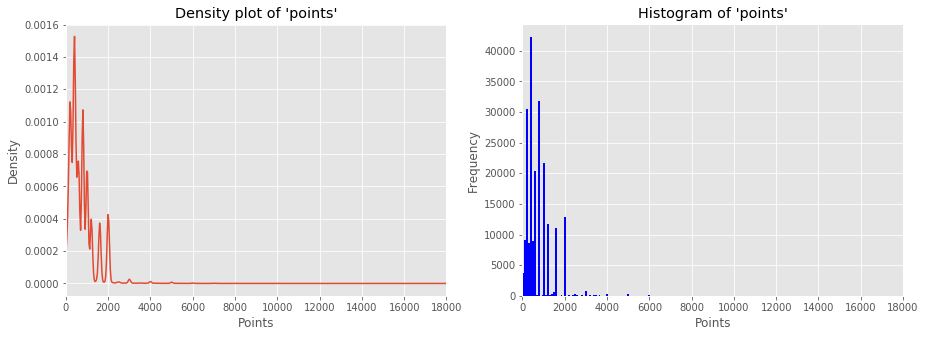

In [6]:
fig, axes=plt.subplots(1,2,figsize=(15,5))
ax1=axes[0]
ax2=axes[1]
jeopardy["points"].plot.kde(ax=ax1,xlim=(0,jeopardy["points"].max()),title="Density plot of 'points'");
jeopardy["points"].plot.hist(ax=ax2,xlim=(0,jeopardy["points"].max()),bins=200,title="Histogram of 'points'",color='blue');
ax1.set_xlabel("Points");
ax2.set_xlabel("Points");

#ax1.density(x=jeopardy["points"],xlim=(0,jeopardy["points"].max()),title="Density plot of 'points'");
#sns.distplot(jeopardy["points"], color='blue');






Data points that are stretched few and far between do not render up meaningful analysis.
Let's take a look at the distribution of points again and then make judgment about which observations from the tails to truncate from further analysis.

Let's drop observations that have "points"==0 right away.


In [7]:
jeopardy.drop(jeopardy.loc[jeopardy["points"]==0].index,inplace=True)
jeopardy["points"].value_counts(normalize=True).sort_index()

#Distribution density of points is shown below 

5        0.000042
20       0.000005
22       0.000005
50       0.000005
100      0.042331
200      0.142783
250      0.000023
300      0.040615
350      0.000009
367      0.000005
400      0.198053
500      0.042270
585      0.000005
600      0.095534
601      0.000005
700      0.000952
750      0.000019
796      0.000005
800      0.149370
900      0.000534
1000     0.101455
1020     0.000005
1100     0.000295
1111     0.000009
1183     0.000005
1200     0.055191
1203     0.000005
1246     0.000005
1263     0.000009
1300     0.000352
           ...   
7500     0.000019
7600     0.000014
7800     0.000038
8000     0.000094
8200     0.000019
8400     0.000014
8500     0.000005
8600     0.000014
8700     0.000005
8800     0.000005
8917     0.000005
9000     0.000038
9200     0.000005
9500     0.000005
9800     0.000005
10000    0.000103
10400    0.000005
10800    0.000028
11000    0.000005
11200    0.000005
11600    0.000005
12000    0.000014
12400    0.000005
13000    0.000014
13200    0

#### Re-distributing 'points' into bins
From above distribution of points we see that the distribution of points is not contiguous. For example, 600 points has distribution density 0.095 but 601 points has distribution density of only 0.000005. 
So if we dropped 601 but retained 600 from our analysis on these grounds, our results would be incoherent.

Therefore, I look at the distribution of various 'bins' of points. That is, I consider _intervals_ rather than a stand alone _point_ of data.

The following block of code narrows our focus of analysis by helping us identify the data points that must be discarded. 
- I distribute "points" into 180 bins of width 100 each.
- This produces some bins that are very sparsely populated, even some empty bins.
- The frequency bar plot below shows the distribution of points in various bins. As can be seen some bins have extremely low frequency (less than 5000 observations)



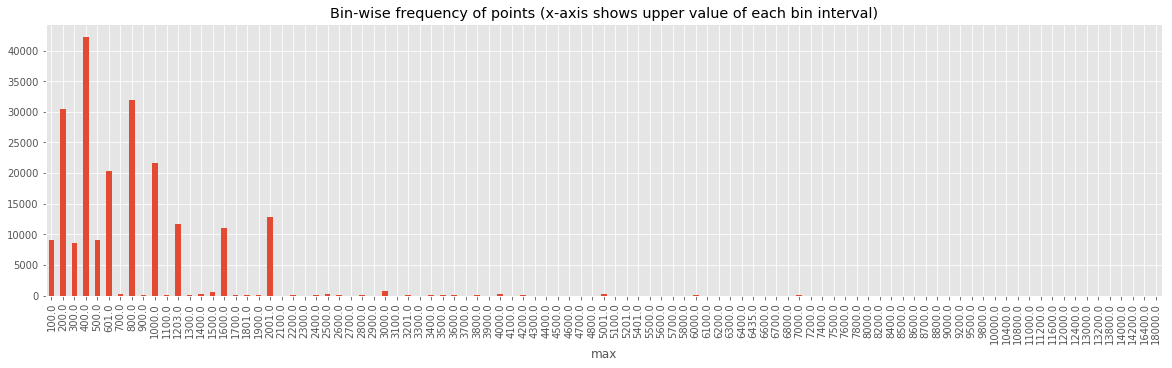

In [8]:
jeopardy["points_bins"]=pd.cut(jeopardy["points"],bins=180).values
dummy=jeopardy.groupby("points_bins")["points"].describe().sort_values("count",ascending=False).reset_index()
dummy.drop(dummy.loc[dummy["count"]==0].index,inplace=True)
dummy.sort_values("max",inplace=True)

(dummy.plot(x="max",y="count",kind='bar',rot=90,figsize=(20,5),legend=False,
            title="Bin-wise frequency of points (x-axis shows upper value of each bin interval)"));

#dummy[dummy["count"]>=5000]["count"].cumsum()

Such low-population bins are identified below and the corresponding observations are dropped from analysis. Relooking at our 'points' distribution.

In [9]:
'''
s=pd.Series(jeopardy.groupby("bins")["points"].count())
s=s[s.values>=5000]
s2=pd.Series(s.index)
jeopardy3=jeopardy[jeopardy["bins"].isin(s2.values)]
jeopardy3["bins"].value_counts()
cols=jeopardy["bins"].cat.remove_unused_categories()
jeopardy2=jeopardy[jeopardy["bins"].isin(cols.values)]
jeopardy2.shape
'''
jeopardy=jeopardy.groupby("points_bins").filter(lambda x: x["points"].count() >=5000)
jeopardy["points"].quantile([0.1,.25,0.5,.75,0.9])


0.10     200.0
0.25     400.0
0.50     600.0
0.75    1000.0
0.90    1600.0
Name: points, dtype: float64

In [10]:
jeopardy["points"].describe()

count    208960.000000
mean        707.408557
std         501.007305
min           5.000000
25%         400.000000
50%         600.000000
75%        1000.000000
max        2001.000000
Name: points, dtype: float64

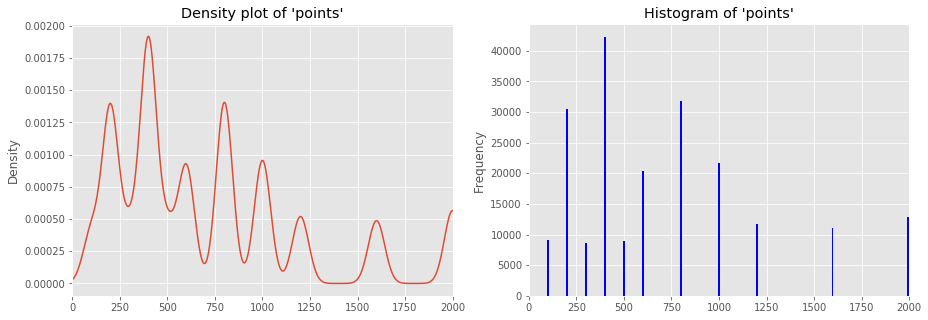

In [11]:
fig2,axes2=plt.subplots(1,2,figsize=(15,5))
jeopardy["points"].plot.kde(ax=axes2[0],xlim=(0,jeopardy["points"].max()),title="Density plot of 'points'");
jeopardy["points"].plot.hist(ax=axes2[1],xlim=(0,jeopardy["points"].max()),bins=200,title="Histogram of 'points'",color='blue');


### Category-wise analysis 
###### (but first...)

There are close to 200 thousand obervations and a quick query using 'jeopardy["Air Date"].dt.year.value_counts()' reveals that we have data from 1984-2012. 
I will use data from 2002-2012 for this analysis and drop the remaining observations.



In [12]:
jeopardy=jeopardy[jeopardy["Air Date"].dt.year>=2002]
jeopardy["clean_cat"]=jeopardy["Category"].apply(stringclean)

np.quantile(jeopardy["clean_cat"].value_counts().values,[0.1,0.25,0.5,0.75,0.9,0.99,0.999])
jeopardy["clean_cat"].value_counts()

#Displayed below is a list of categories and the number of questions that were asked from each, between 2002-2012

before  after                                309
science                                      199
stupid answers                               199
potpourri                                    169
americana                                    154
word origins                                 146
rhyme time                                   143
bodies of water                              131
pop culture                                  128
3letter words                                128
opera                                        123
colleges  universities                       121
world capitals                               120
art  artists                                 117
common bonds                                 117
literature                                   112
ballet                                       111
10letter words                               108
poets  poetry                                107
annual events                                106
musical instruments 

###### Distribution of questions across categories...

Here, I take a count of questions from each category, that is, how frequently were questions asked from each category. On arranging the various categories in order of frequency it is observed that there is a lot of variance across categories: percentile figures of question frequency are as follows
-  10th percentile category -> 5 questions asked between 2002-2012
-  25th percentile category -> 5 questions asked between 2002-2012
-  50th percentile category -> 5 questions asked between 2002-2012
-  75th percentile category -> 5 questions asked between 2002-2012
-  90th percentile category -> 10 questions asked between 2002-2012
-  99th percentile category -> 36 questions asked between 2002-2012
-  99.9th percentile category -> 113 questions asked between 2002-2012

Let's consider only high-frequency categories for further analysis. That is, only those categories that saw more than 36 questions asked in the period 2002-2012.
Following block of code accomplishes this goal.

In [13]:
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,points,points_bins,clean_cat
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200,"(104.972, 204.944]",history
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,200,"(104.972, 204.944]",espns top 10 alltime athletes
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,200,"(104.972, 204.944]",everybody talks about it
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,200,"(104.972, 204.944]",the company line
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,200,"(104.972, 204.944]",epitaphs tributes


In [20]:
jeopardy=jeopardy.groupby("clean_cat").filter(lambda x: x["clean_cat"].count() >=36)
jeopardy["clean_cat"].value_counts()

before  after             309
stupid answers            199
science                   199
potpourri                 169
americana                 154
word origins              146
rhyme time                143
bodies of water           131
3letter words             128
pop culture               128
opera                     123
colleges  universities    121
world capitals            120
art  artists              117
common bonds              117
literature                112
ballet                    111
10letter words            108
poets  poetry             107
annual events             106
musical instruments       106
american history          105
classical music           104
abbrev                     99
us cities                  97
homophones                 96
nonfiction                 95
world history              95
books  authors             94
shakespeare                93
                         ... 
13letter words             40
food                       40
early amer

Even after removing insignificant categories we are left with 184 categories. Categories that have similar question-frequencies can be grouped into a single bin. That is, from analysis perspective there is not much difference between, say, Category A that saw 40 questions and Category B that saw 41 questions. So both of them can be bunched into 1 bin.

Following block of code divides the 184 categories into 14 bins of width 20 each (approximately).
This should be interpreted as: 
-  All categories that saw 38-58 number of questions fall in the 1st bin. (38 is the minimum # of questions from any category, in our analysis)
-  All categories that saw 59-79 number of questions fall in the 2nd bin. 
-  All categories that saw 80-100 number of questions fall in the 3rd bin and so on.... until the 14th bin.

In [15]:
cat_freq_bin=dict(pd.cut(jeopardy["clean_cat"].value_counts(),bins=14))
jeopardy["question_freq_bin"]=jeopardy["clean_cat"].map(cat_freq_bin)
jeopardy.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,points,points_bins,clean_cat,question_freq_bin
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200,"(104.972, 204.944]",history,"(35.727, 55.5]"
5,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$200,"In the title of an Aesop fable, this insect sh...",the ant,in the title of an aesop fable this insect sha...,the ant,200,"(104.972, 204.944]",3letter words,"(114.0, 133.5]"
6,4680,2004-12-31,Jeopardy!,HISTORY,$400,Built in 312 B.C. to link Rome & the South of ...,the Appian Way,built in 312 bc to link rome the south of ita...,the appian way,400,"(304.917, 404.889]",history,"(35.727, 55.5]"
11,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$400,Cows regurgitate this from the first stomach t...,the cud,cows regurgitate this from the first stomach t...,the cud,400,"(304.917, 404.889]",3letter words,"(114.0, 133.5]"
12,4680,2004-12-31,Jeopardy!,HISTORY,$600,In 1000 Rajaraja I of the Cholas battled to ta...,Ceylon (or Sri Lanka),in 1000 rajaraja i of the cholas battled to ta...,ceylon or sri lanka,600,"(504.861, 604.833]",history,"(35.727, 55.5]"


In [16]:
jeopardy.groupby("question_freq_bin")["points"].describe()

,count,mean,std,min,25%,50%,75%,max
question_freq_bin,,,,,,,,
"(35.727, 55.5]",4113.0,916.898857,550.054487,5.0,400.0,800.0,1200.0,2000.0
"(55.5, 75.0]",2693.0,933.809877,555.471939,100.0,400.0,800.0,1200.0,2000.0
"(75.0, 94.5]",1499.0,937.158105,559.825629,200.0,400.0,800.0,1200.0,2000.0
"(94.5, 114.0]",1341.0,929.828486,552.151059,200.0,400.0,800.0,1200.0,2000.0
"(114.0, 133.5]",985.0,950.964467,561.937690,200.0,400.0,800.0,1200.0,2000.0
"(133.5, 153.0]",289.0,907.266436,552.251517,200.0,400.0,800.0,1200.0,2000.0
"(153.0, 172.5]",323.0,801.857585,494.060642,200.0,400.0,800.0,1000.0,2000.0
"(192.0, 211.5]",398.0,817.587940,507.666376,200.0,400.0,800.0,1000.0,2000.0
"(289.5, 309.0]",309.0,1111.326861,579.773679,200.0,600.0,1200.0,1600.0,2000.0


In [17]:
jeopardy

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,points,points_bins,clean_cat,question_freq_bin
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200,"(104.972, 204.944]",history,"(35.727, 55.5]"
5,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$200,"In the title of an Aesop fable, this insect sh...",the ant,in the title of an aesop fable this insect sha...,the ant,200,"(104.972, 204.944]",3letter words,"(114.0, 133.5]"
6,4680,2004-12-31,Jeopardy!,HISTORY,$400,Built in 312 B.C. to link Rome & the South of ...,the Appian Way,built in 312 bc to link rome the south of ita...,the appian way,400,"(304.917, 404.889]",history,"(35.727, 55.5]"
11,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$400,Cows regurgitate this from the first stomach t...,the cud,cows regurgitate this from the first stomach t...,the cud,400,"(304.917, 404.889]",3letter words,"(114.0, 133.5]"
12,4680,2004-12-31,Jeopardy!,HISTORY,$600,In 1000 Rajaraja I of the Cholas battled to ta...,Ceylon (or Sri Lanka),in 1000 rajaraja i of the cholas battled to ta...,ceylon or sri lanka,600,"(504.861, 604.833]",history,"(35.727, 55.5]"
17,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$600,"A small demon, or a mischievous child (who mig...",imp,a small demon or a mischievous child who might...,imp,600,"(504.861, 604.833]",3letter words,"(114.0, 133.5]"
18,4680,2004-12-31,Jeopardy!,HISTORY,$800,Karl led the first of these Marxist organizati...,the International,karl led the first of these marxist organizati...,the international,800,"(704.806, 804.778]",history,"(35.727, 55.5]"
23,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$800,"In geologic time one of these, shorter than an...",era,in geologic time one of these shorter than an ...,era,800,"(704.806, 804.778]",3letter words,"(114.0, 133.5]"
24,4680,2004-12-31,Jeopardy!,HISTORY,$1000,This Asian political party was founded in 1885...,the Congress Party,this asian political party was founded in 1885...,the congress party,1000,"(904.75, 1004.722]",history,"(35.727, 55.5]"
28,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$1000,"A single layer of paper, or to perform one's c...",ply,a single layer of paper or to perform ones cra...,ply,1000,"(904.75, 1004.722]",3letter words,"(114.0, 133.5]"


In [22]:
jeopardy2=jeopardy.copy()


In [23]:
jeopardy["question_count"]=jeopardy.groupby("question_freq_bin")["clean_cat"].transform('count')
jeopardy["category_classification"]=jeopardy["question_count"].apply(lambda x:"High frequency" if x>2000 else ("Medium frequency" if x>1000 else "Low frequency"))
jeopardy




,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,points,points_bins,clean_cat,question_freq_bin,year,question_count,category_classification
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,200,"(104.972, 204.944]",history,"(35.727, 55.5]",2004,4113,High frequency
5,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$200,"In the title of an Aesop fable, this insect sh...",the ant,in the title of an aesop fable this insect sha...,the ant,200,"(104.972, 204.944]",3letter words,"(114.0, 133.5]",2004,985,Low frequency
6,4680,2004-12-31,Jeopardy!,HISTORY,$400,Built in 312 B.C. to link Rome & the South of ...,the Appian Way,built in 312 bc to link rome the south of ita...,the appian way,400,"(304.917, 404.889]",history,"(35.727, 55.5]",2004,4113,High frequency
11,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$400,Cows regurgitate this from the first stomach t...,the cud,cows regurgitate this from the first stomach t...,the cud,400,"(304.917, 404.889]",3letter words,"(114.0, 133.5]",2004,985,Low frequency
12,4680,2004-12-31,Jeopardy!,HISTORY,$600,In 1000 Rajaraja I of the Cholas battled to ta...,Ceylon (or Sri Lanka),in 1000 rajaraja i of the cholas battled to ta...,ceylon or sri lanka,600,"(504.861, 604.833]",history,"(35.727, 55.5]",2004,4113,High frequency
17,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$600,"A small demon, or a mischievous child (who mig...",imp,a small demon or a mischievous child who might...,imp,600,"(504.861, 604.833]",3letter words,"(114.0, 133.5]",2004,985,Low frequency
18,4680,2004-12-31,Jeopardy!,HISTORY,$800,Karl led the first of these Marxist organizati...,the International,karl led the first of these marxist organizati...,the international,800,"(704.806, 804.778]",history,"(35.727, 55.5]",2004,4113,High frequency
23,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$800,"In geologic time one of these, shorter than an...",era,in geologic time one of these shorter than an ...,era,800,"(704.806, 804.778]",3letter words,"(114.0, 133.5]",2004,985,Low frequency
24,4680,2004-12-31,Jeopardy!,HISTORY,$1000,This Asian political party was founded in 1885...,the Congress Party,this asian political party was founded in 1885...,the congress party,1000,"(904.75, 1004.722]",history,"(35.727, 55.5]",2004,4113,High frequency
28,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,$1000,"A single layer of paper, or to perform one's c...",ply,a single layer of paper or to perform ones cra...,ply,1000,"(904.75, 1004.722]",3letter words,"(114.0, 133.5]",2004,985,Low frequency


### Categories are now sorted by frequency, into "High", "Medium", and "Low". Let's see if there is a time trend in each category.



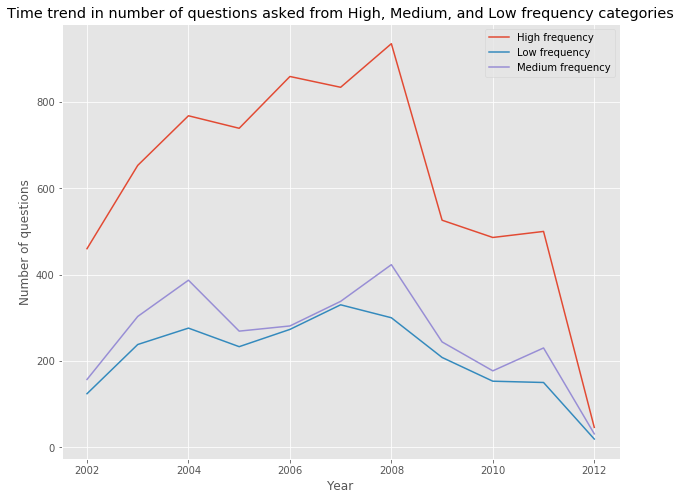

In [24]:
plt.figure(figsize=(10,8))
jeopardy["year"]=jeopardy["Air Date"].dt.year
dummy=jeopardy.groupby(["category_classification","year"])["points"].describe()["count"].reset_index()


y=dummy.loc[dummy["category_classification"]=="High frequency","count"]
x=dummy.loc[dummy["category_classification"]=="High frequency","year"]
plt.plot(x,y,label="High frequency");

y=dummy.loc[dummy["category_classification"]=="Low frequency","count"]
x=dummy.loc[dummy["category_classification"]=="Low frequency","year"]
plt.plot(x,y,label="Low frequency");

y=dummy.loc[dummy["category_classification"]=="Medium frequency","count"]
x=dummy.loc[dummy["category_classification"]=="Medium frequency","year"]
plt.plot(x,y,label="Medium frequency");
plt.xlabel("Year")
plt.ylabel("Number of questions")
plt.title("Time trend in number of questions asked from High, Medium, and Low frequency categories")
plt.legend()
plt.show()


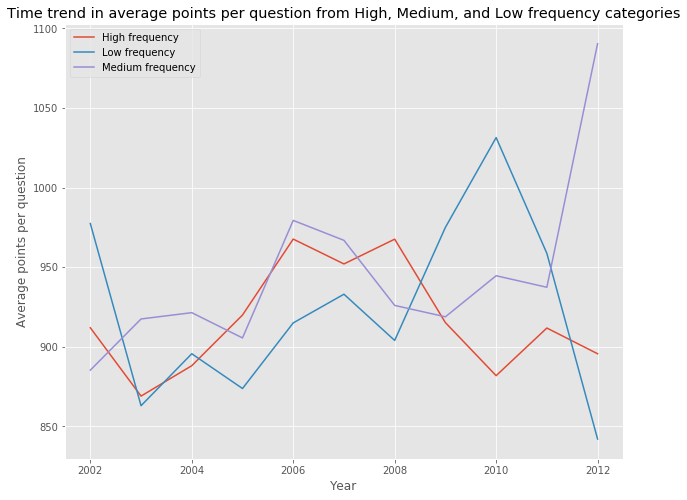

In [25]:
plt.figure(figsize=(10,8))
dummy1=jeopardy.groupby(["category_classification","year"])["points"].describe()["mean"].reset_index()
dummy1.rename(columns={"mean":"Average points"},inplace=True)

y=dummy1.loc[dummy["category_classification"]=="High frequency","Average points"]
x=dummy1.loc[dummy["category_classification"]=="High frequency","year"]
plt.plot(x,y,label="High frequency");

y=dummy1.loc[dummy["category_classification"]=="Low frequency","Average points"]
x=dummy1.loc[dummy["category_classification"]=="Low frequency","year"]
plt.plot(x,y,label="Low frequency");

y=dummy1.loc[dummy["category_classification"]=="Medium frequency","Average points"]
x=dummy1.loc[dummy["category_classification"]=="Medium frequency","year"]
plt.plot(x,y,label="Medium frequency");
plt.xlabel("Year")
plt.ylabel("Average points per question")
plt.title("Time trend in average points per question from High, Medium, and Low frequency categories")
plt.legend()
plt.show()


## Analysis of questions

Below is a primitive device to check whether the **question offers a clue to its answer**. I achieve this objective by finding out the average number of words in an answer that are also found in the question. I have excluded trivial words like "the", "a", and "is" from this check. 
The result returned is approximately 0.054 words. 

**This should be interpreted as follows**: If the answer is 100 words long, then on average there are between 5 and 6 non-trivial words in the answer which also occur in the question.

In [ ]:
def clueinquestioncheck(row):
    split_answer=row["clean_answer"].split(" ")
    split_question=row["clean_question"].split(" ")
    match_count=0
    redundant=['the','a','is']
    for r in redundant:
        while r in split_answer:
            split_answer.remove(r)
    if len(split_answer)==0:
        return 0
    
    
    for word in split_answer:
        if word in split_question:
            match_count+=1
    return (match_count/len(split_answer))

jeopardy["answer_in_question"]=jeopardy.apply(clueinquestioncheck,axis=1)
clue_in_question_freq=jeopardy["answer_in_question"].mean()
print(clue_in_question_freq)

        

    


Below is a primitive device to check **if questions are repeated**. The protocol used is: for every question check for repetitions of complex words(a word is considered complex if it has more than 5 characters. This definition is arbitrary). The output presented below, 4.75, is the average number of complex words per question that have appeared in another question that has been asked previously.

In [ ]:
used_words=set()
jeopardy=jeopardy.sort_values(by=['Air Date'])
for i,row in jeopardy.iterrows():
    match_counter=0
    split_question=row["clean_question"].split(" ")
    for each in split_question:
        if len(each)>=5:
            if each in used_words:
                match_counter+=1
            used_words.add(each)
    jeopardy.loc[i,"question_overlap_count"]=match_counter
question_overlap=jeopardy["question_overlap_count"].mean()
print(question_overlap)

    
        
      

                        
        